In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns


In [2]:
# === 2. Load and Preprocess the Dataset ===
df = pd.read_csv('/content/handover_dataset_custom.csv')

# Clean and convert necessary fields
df['Signal_Str'] = df['Signal_Str'].str.replace(' dBm', '').astype(float)
df['Latency'] = df['Latency'].str.replace(' ms', '').astype(float)
df['Required_'] = df['Required_'].str.replace(' Mbps', '').astype(float)
df['Allocated_'] = df['Allocated_'].str.replace(' Mbps', '').astype(float)
df['Resource_Allocation'] = df['Resource_Allocation'].str.replace('%', '').astype(float)

# One-hot encode application names
df = pd.get_dummies(df, columns=['Application'], drop_first=True)

# === Features and Target ===
X = df.drop(columns=['Timestamp', 'User_ID', 'Resource_Allocation'])
y = df['Resource_Allocation']

# === Train-Test Split & Scaling ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
# === 3. Define Base and Ensemble Models ===
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42),
}

# Add Voting and Stacking Regressors
models["Voting Regressor"] = VotingRegressor(estimators=[
    ('rf', models["Random Forest"]),
    ('gb', models["Gradient Boosting"])
])

models["Stacking Regressor"] = StackingRegressor(estimators=[
    ('rf', models["Random Forest"]),
    ('gb', models["Gradient Boosting"]),
    ('xgb', models["XGBoost"])
], final_estimator=Ridge())


In [4]:
# === 4. Train and Evaluate Models ===
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({"Model": name, "R2_Score": round(r2, 4), "RMSE": round(rmse, 4)})

results_df = pd.DataFrame(results).sort_values(by='R2_Score', ascending=False)
display(results_df)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 12
[LightGBM] [Info] Start training from score 70.351111


,Model,R2_Score,RMSE
6,Stacking Regressor,0.9964,1.1486
0,Random Forest,0.9959,1.2141
3,XGBoost,0.9952,1.3150
4,LightGBM,0.9935,1.5287
5,Voting Regressor,0.9917,1.7313
1,Gradient Boosting,0.9799,2.6989
2,AdaBoost,0.8999,6.0165


In [5]:
# Normalize y between 0 and 1
from sklearn.preprocessing import MinMaxScaler

target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()


In [6]:
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test_scaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred))


In [7]:
from sklearn.metrics import r2_score, mean_squared_error

# === Re-train & Evaluate with Normalized y ===
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train_scaled)  # Note: scaled y
    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test_scaled, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred))

    results.append({
        "Model": name,
        "R2_Score": round(r2, 4),
        "RMSE": round(rmse, 4)
    })

# === Display Results ===
results_df = pd.DataFrame(results).sort_values(by='R2_Score', ascending=False).reset_index(drop=True)
results_df


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 12
[LightGBM] [Info] Start training from score 0.727122


,Model,R2_Score,RMSE
0,Random Forest,0.9959,0.0146
1,Stacking Regressor,0.9959,0.0147
2,XGBoost,0.9952,0.0159
3,LightGBM,0.9935,0.0184
4,Voting Regressor,0.9917,0.0208
5,Gradient Boosting,0.9799,0.0325
6,AdaBoost,0.8947,0.0743


In [8]:
# === 5. Cross Validation ===
cv_results = []

for name, model in models.items():
    X_cv = X_train_scaled if name != "LightGBM" else X_train
    scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='r2')
    cv_results.append({
        "Model": name,
        "Mean CV R²": round(np.mean(scores), 4),
        "Std Dev": round(np.std(scores), 4)
    })

cv_df = pd.DataFrame(cv_results).sort_values(by='Mean CV R²', ascending=False)
display(cv_df)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 12
[LightGBM] [Info] Start training from score 70.056944
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 12
[LightGBM] [Info] Start training from score 70.468750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 12
[LightGBM] [Info] Start trainin

,Model,Mean CV R²,Std Dev
6,Stacking Regressor,0.9950,0.0010
0,Random Forest,0.9946,0.0010
3,XGBoost,0.9936,0.0010
4,LightGBM,0.9920,0.0017
5,Voting Regressor,0.9898,0.0012
1,Gradient Boosting,0.9762,0.0022
2,AdaBoost,0.8896,0.0051


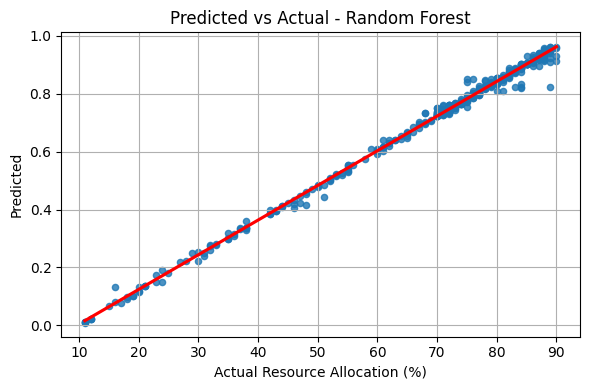

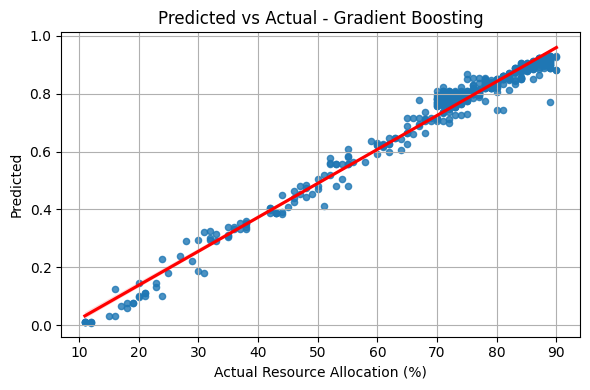

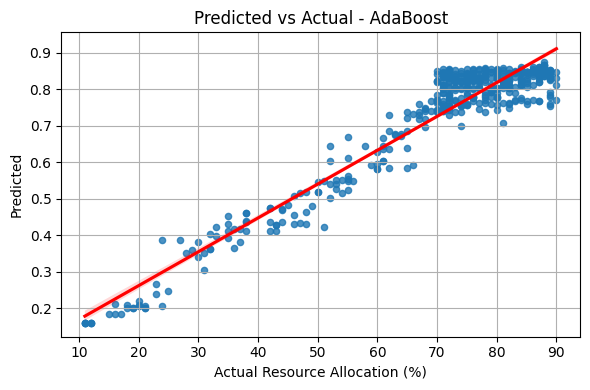

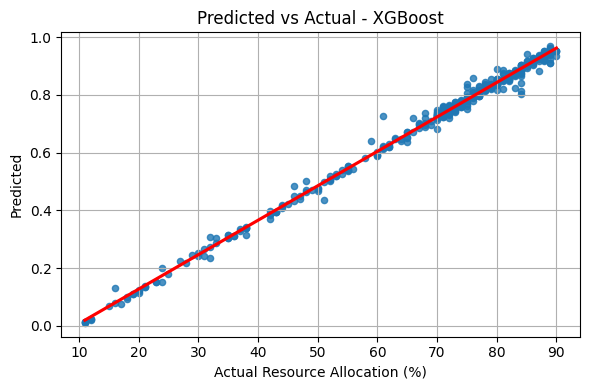

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


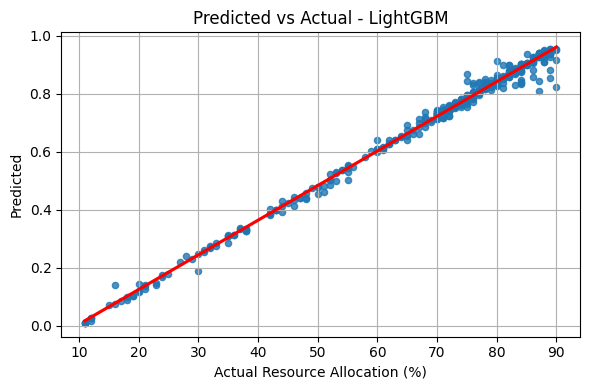

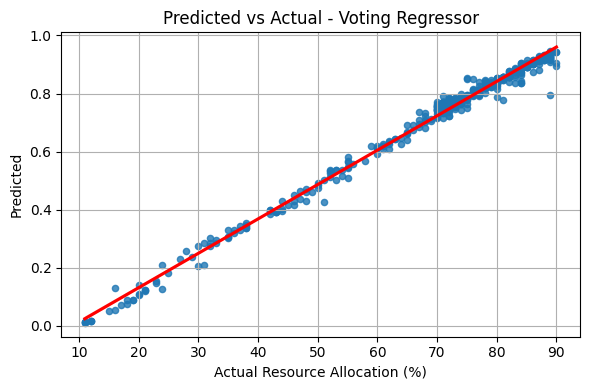

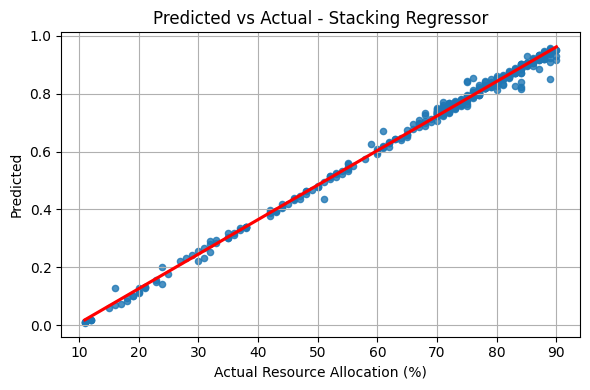

In [9]:
# === 6. Predicted vs Actual Plot for All Models ===
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    plt.figure(figsize=(6,4))
    sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20}, line_kws={"color": "red"})
    plt.xlabel("Actual Resource Allocation (%)")
    plt.ylabel("Predicted")
    plt.title(f"Predicted vs Actual - {name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**MSE CALCULATION**

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load your dataset
df = pd.read_csv('handover_dataset_custom.csv')

# Clean the columns (remove units)
df['Resource_Allocation'] = df['Resource_Allocation'].str.replace('%', '').astype(float)

# Scale target variable between 0 and 1
scaler_target = MinMaxScaler()
y_scaled = scaler_target.fit_transform(df[['Resource_Allocation']]).ravel()

# Prepare features
df['Signal_Str'] = df['Signal_Str'].str.replace(' dBm', '').astype(float)
df['Latency'] = df['Latency'].str.replace(' ms', '').astype(float)
df['Allocated_'] = df['Allocated_'].str.replace(' Mbps', '').astype(float)
df['Required_'] = df['Required_'].str.replace(' Mbps', '').astype(float)

# If you have Application column, one-hot encode it
if 'Application' in df.columns:
    df = pd.get_dummies(df, columns=['Application'], drop_first=True)

# Drop non-numeric identifiers
X = df.drop(columns=['Timestamp', 'User_ID', 'Resource_Allocation'])
y = y_scaled

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42),
}

# Add ensemble models
models['Voting Regressor'] = VotingRegressor(estimators=[
    ('rf', models['Random Forest']),
    ('gb', models['Gradient Boosting'])
])

models['Stacking Regressor'] = StackingRegressor(estimators=[
    ('rf', models['Random Forest']),
    ('gb', models['Gradient Boosting']),
    ('xgb', models['XGBoost'])
], final_estimator=Ridge())

# Train and evaluate
mse_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_results.append({'Model': name, 'MSE (Scaled)': round(mse, 6)})

# Create result table
mse_df = pd.DataFrame(mse_results).sort_values(by='MSE (Scaled)').reset_index(drop=True)
print(mse_df)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 12
[LightGBM] [Info] Start training from score 0.727122
                Model  MSE (Scaled)
0       Random Forest      0.000213
1  Stacking Regressor      0.000215
2             XGBoost      0.000252
3            LightGBM      0.000337
4    Voting Regressor      0.000434
5   Gradient Boosting      0.001057
6            AdaBoost      0.005371


In [11]:
mse_df = pd.DataFrame(mse_results).sort_values(by='MSE (Scaled)').reset_index(drop=True)
print(mse_df)

                Model  MSE (Scaled)
0       Random Forest      0.000213
1  Stacking Regressor      0.000215
2             XGBoost      0.000252
3            LightGBM      0.000337
4    Voting Regressor      0.000434
5   Gradient Boosting      0.001057
6            AdaBoost      0.005371
